In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from comparers import ModelComparer
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '01'

In [3]:
with open(task_name + '.dataset', 'rb') as f:
    X, display_data, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [4]:
idx_explain = 0

In [5]:
y = y.astype(str)
d = dict([(feature_name, feature_data)
          for feature_name, feature_data
          in zip(feature_names, [x for x in X.T])])
d |= {'y': y}
df = pd.DataFrame(d)
dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [6]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)

CPU times: user 18.4 s, sys: 245 ms, total: 18.7 s
Wall time: 20.1 s


In [7]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([577,  54]))


In [8]:
value = 0
width = X.shape[0]
filler_feature_values = {1: value, 3: value, 4: value, 5: value, 6: value, 7: value, 8: value, 9: value, 10: value, 11: value}
filler_feature_ranges = {1: width, 3: width, 4: width, 5: width, 6: width, 7: width, 8: width, 9: width, 10: width, 11: width}

No contour levels were found within the data range.
No contour levels were found within the data range.
Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
No contour levels were found within the data range.


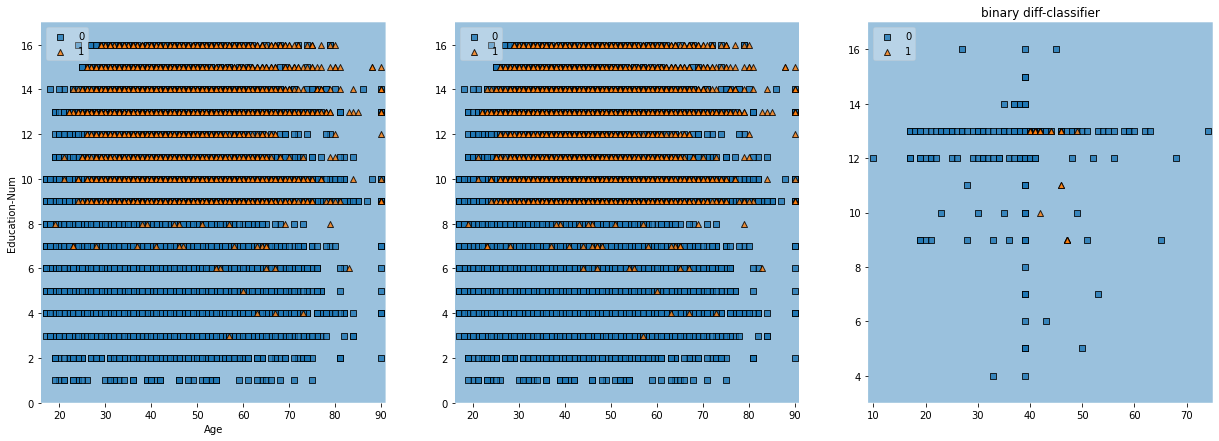

In [9]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.integer), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
plt.title('binary diff-classifier')

plt.show()

[Text(310.0, 815.4, 'Age <= 39.5\ngini = 0.157\nsamples = 631\nvalue = [577, 54]\nclass = no_diff'),
 Text(155.0, 634.2, 'gini = 0.0\nsamples = 523\nvalue = [523, 0]\nclass = no_diff'),
 Text(465.0, 634.2, 'Relationship <= 2.0\ngini = 0.5\nsamples = 108\nvalue = [54, 54]\nclass = no_diff'),
 Text(310.0, 453.0, 'gini = 0.0\nsamples = 50\nvalue = [50, 0]\nclass = no_diff'),
 Text(620.0, 453.0, 'Age <= 51.5\ngini = 0.128\nsamples = 58\nvalue = [4, 54]\nclass = diff'),
 Text(465.0, 271.80000000000007, 'Education-Num <= 7.5\ngini = 0.036\nsamples = 55\nvalue = [1, 54]\nclass = diff'),
 Text(310.0, 90.60000000000002, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = no_diff'),
 Text(620.0, 90.60000000000002, 'gini = 0.0\nsamples = 54\nvalue = [0, 54]\nclass = diff'),
 Text(775.0, 271.80000000000007, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = no_diff')]

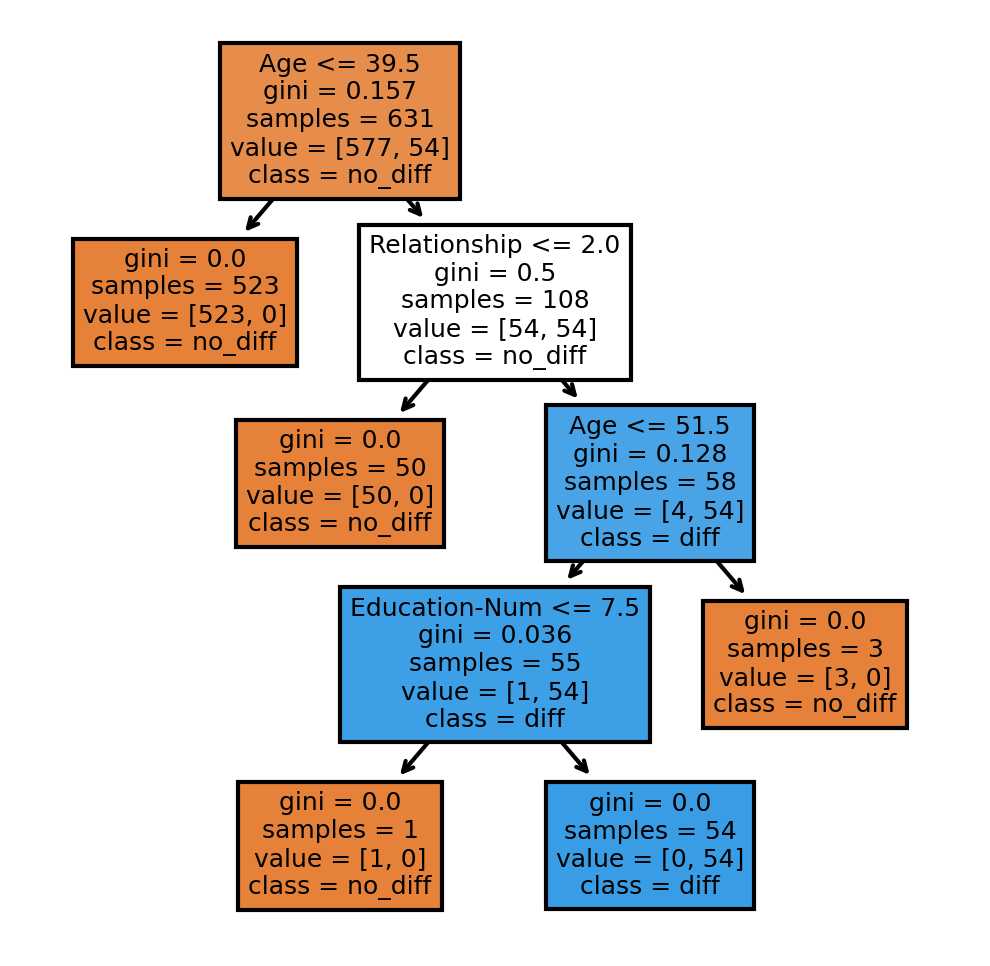

In [10]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [11]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{Age > 39.5, Relationship > 2.0, Age <= 51.5, Education-Num > 7.5}'}


## Multiclass difference explanations

In [12]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [13]:
%%time
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_modified_genetic_neighborhood)

CPU times: user 17.6 s, sys: 203 ms, total: 17.8 s
Wall time: 18.7 s


In [14]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 4]), array([555,  34,  69]))


No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


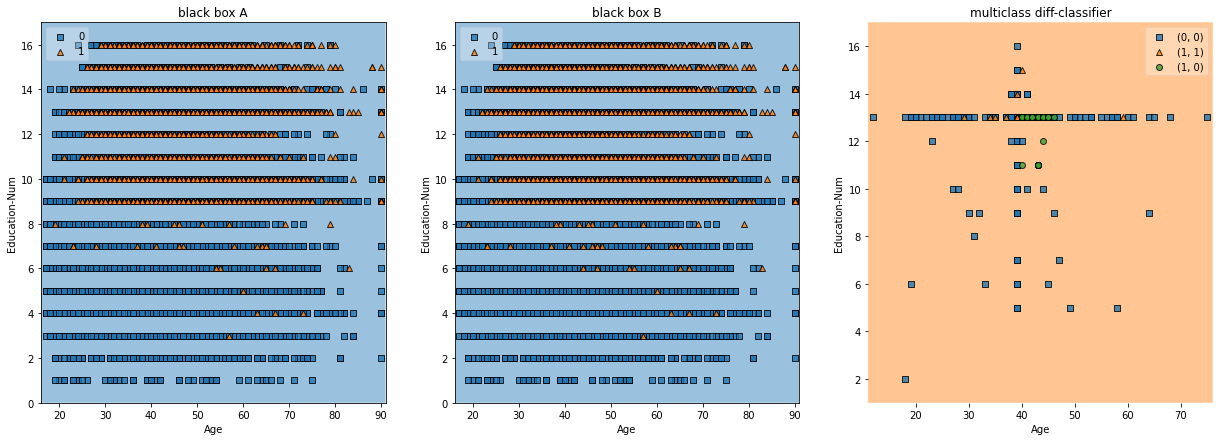

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(np.int64), clf=comparer.clf_a, ax=ax[0], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[2])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(np.int64), clf=comparer.clf_b, ax=ax[1], legend=2,
                            hide_spines=False, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[2])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(np.int64), clf=dc_full, ax=ax[2], legend=2, feature_index=[0, 2], 
                            filler_feature_values=filler_feature_values, filler_feature_ranges=filler_feature_ranges)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[2])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(368.5975609756098, 855.6666666666666, 'Relationship <= 2.5\ngini = 0.275\nsamples = 658\nvalue = [555, 34, 69]\nclass = (0, 0)'),
 Text(181.46341463414635, 755.0, 'Capital Gain <= 7493.0\ngini = 0.04\nsamples = 535\nvalue = [524, 7, 4]\nclass = (0, 0)'),
 Text(136.09756097560975, 654.3333333333333, 'Capital Loss <= 2330.5\ngini = 0.015\nsamples = 528\nvalue = [524, 0, 4]\nclass = (0, 0)'),
 Text(90.73170731707317, 553.6666666666666, 'Capital Loss <= 1785.5\ngini = 0.004\nsamples = 525\nvalue = [524, 0, 1]\nclass = (0, 0)'),
 Text(45.36585365853659, 453.0, 'gini = 0.0\nsamples = 522\nvalue = [522, 0, 0]\nclass = (0, 0)'),
 Text(136.09756097560975, 453.0, 'Age <= 41.5\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 1]\nclass = (0, 0)'),
 Text(90.73170731707317, 352.33333333333326, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]\nclass = (0, 0)'),
 Text(181.46341463414635, 352.33333333333326, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = (1, 0)'),
 Text(181.46341463414635, 553.6666666

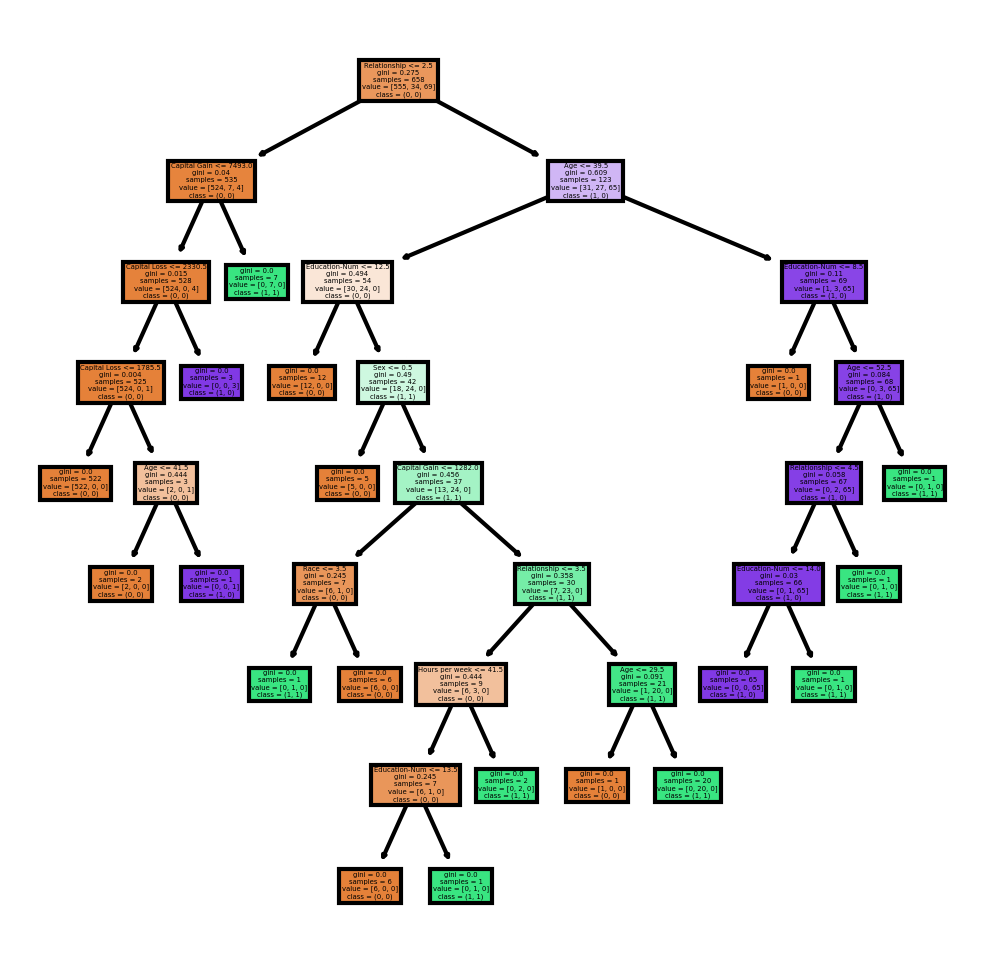

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)